## GEO371T/GEO391 - Introduction to Machine Learning for Geosciences
### Experimenting with Different Optimizers
#### What should you take from this notebook?

* Become familiar with what an optimization problem is, the different types of optimization methods, and how to implement/code these various types of optimizers

__What is an optimization problem?__
* An optimization problem refers to the use of a particular method/algorithm as a means to find the optimal solution out of the set of all possible solutions for a given problem
    * To do this we define a **cost function** and seek to minimize (or maximize) it.
        * The cost function gives a measure of the difference between our model predictions/estimates and actual/observed data
        * There are many synonyms for cost function depending on the field (i.e., loss function, error function, scoring function, etc.)


-----

__What are the various types of optimization problems and their associated optimization method/algorithm?__

* **Direct Solution**:
In some cases we can directly solve an optimization problem like the linear least squares problem.

$\min ||Xw-y||_2$

Here X is a matrix of features, y is the target, and w are the weights to be 'learned'. Recall from lecture that the double bars $||x||_p$ indicate the $p$-norm of the vector x.
For an n-dimensional real valued vector (i.e. $x\in\mathbb{R}^N$):

$||x||_p := (x_1^{p}+x_2^{p}+...+x_N^{p})^{1/p}$ 

This optimization problem has the direct solution

$w=(X^TX)^{-1}X^Ty$

In other cases, we cannot directly obtain a solution or a direct solution is computationally infeasible due to inverting the matrix $(X^TX)$. Direct matrix inversion, in general, has a involves $\mathcal{O}(n^3)$ floating point operations.

* **Local Optimization**: 
In the case that we cannot directly solve for $w$, we can make an initial quess $w_0$ and find the best solution $w^*$ local to $w_0$.
    
    * Types of optimization methods/algorithms used:
        * Gradient Descent (i.e., Steepest Descent)
        * Conjugate Gradients
        * ADAM
        * Newton - (Includes Hessian, second order)

* **Directed Random Search**     
    * Very fast simulated annealing (VFSA)
    
* Note that there are many more types of optimization problems and algorithms used for such a problem.


In [2]:
import numpy as np
import pandas as pd
import math
import random
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.optimize as opt
import warnings                         # Allows the code to ignore uneccessary warnings
warnings.filterwarnings('ignore')

## Let us now consider the problem of minimizing the Rosenbrock function. 

In two dimensions, the function is
$f(x,y)=(a-x)^{2}+b(y-x^{2})^{2}$
and has a global minimum $f(a, a^2)=0$

The function has a parabolic 'valley' which is easy for local optimizers to converge to. However, the global minimum is difficult to obtain. This makes the function useful for studying the convergence of local optimizers; in fact, the function was designed for this purpose.

The Rosenbrok function and its respective derivatives are implemented in Rosen (rosen_der, rosen_hess) in the scipy.optimize

Note that scipy uses $a=1$ and $b=100$ by default.


## Let's plot the Rosenbrock function in 2D


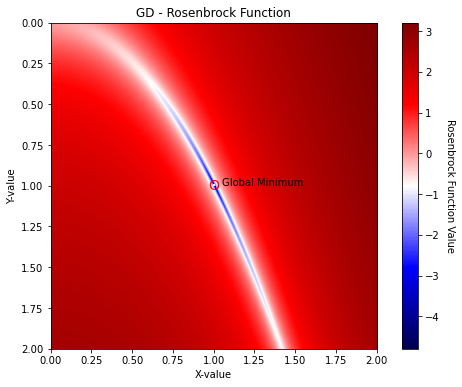

In [3]:
from scipy.optimize import minimize, rosen, rosen_der, rosen_hess

#Define arrays to store values of the Rosenbrok function 
k = np.linspace(0.0, 2.0, 501)
f = np.empty((k.shape[0], k.shape[0]))
kx = k 
ky = k

#Fill values for the rosenbrock function
for i in range(0, len(k)):
    for j in range(0, len(k)):
        f[i, j] = rosen(np.array([kx[j], ky[i]]))

#Plot
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
cax = ax.imshow(np.log10(f), extent=[k[0], k[-1], k[-1], k[0]], cmap='seismic')
cbar = fig.colorbar(cax)
cbar.set_label('Rosenbrock Function Value', rotation=270, labelpad=15)
plt.title('GD - Rosenbrock Function')
ax.set_xlabel('X-value')
ax.set_ylabel('Y-value')


# The below code marks the global minimum
plt.text(1.0, 1.0, 'O', size=14, color='red',horizontalalignment='center', verticalalignment='center',\
         bbox=dict(facecolor='green', alpha=0.01))
plt.text(1.05, 1.00, 'Global Minimum')
plt.show()

# Let's apply some optimization algorithms now. 

## The Optimization class below contains Gradient Descent, Newton, ADAM, and VFSA

### mks 9/13/2020

In [4]:
from scipy.optimize import rosen, rosen_der, rosen_hess
import numpy as np, matplotlib.pyplot as plt
from numpy.random import *

class Optimize():

    def gd(self,x,n_epochs,learning_rate):
        f_old=999999.
        f=np.zeros(n_epochs)
        imax=n_epochs
        for i in range(0,n_epochs):
            x -= learning_rate*rosen_der(x)
            f_new = rosen(x)
            if (f_new > f_old):
                print('solution diverging at epoch no: ', i)
                imax=i-1
                break
            f_old=f_new
            f[i]=f_old

        ff=str(f_new)
        print('Optimal value of the function found = ', f_new)
        plt.plot(f[0:imax],'x')
        plt.xlabel('Epoch')
        plt.ylabel('function value')
        plt.grid()
        plt.suptitle('Rosenbrock function: Gradient Descent',fontsize=30)
        plt.show()
    
        return x
        
#Gradient Descent algorithm with line search
    def gd_line_search(self,x,n_epochs,learning_rate,a,b):
        f_old=999999.
        f=np.zeros(n_epochs)
        imax=n_epochs
        for i in range(0,n_epochs):
            #Find the optimal learning rate using the golden section function
            f_gss = lambda alpha: rosen(x-alpha*rosen_der(x))
            learning_rate = opt.gss(f_gss,a,b)
            x -= learning_rate*rosen_der(x)
            f_new = rosen(x)
            if (f_new > f_old):
                print('solution diverging at epoch no: ', i)
                imax=i-1
                break
            f_old=f_new
            f[i]=f_old

        ff=str(f_new)
        print('Optimal value of the function found = ', f_new)
        plt.plot(f[0:imax],'x')
        plt.xlabel('Epoch')
        plt.ylabel('function value')
        plt.grid()
        plt.suptitle('Rosenbrock function: Gradient Descent with Line Search',fontsize=20)
        plt.show()

        return x



    ####################################
    def Newton(self,x,n_epochs,learning_rate):
    ####################################
        f_old=999999.
        f=np.zeros(n_epochs)
        imax=n_epochs
        for i in range(0,n_epochs):
            H=(rosen_hess(x))
            x -= learning_rate*np.dot(np.linalg.inv(H),rosen_der(x))
            f_new = rosen(x)
            if (f_new > f_old):
                print('solution diverging at epoch no: ', i)
                imax=i-1
                break
            f_old=f_new
            f[i]=f_old
    
        print('Optimal value of the function found = ', f_new)
        plt.plot(f[0:imax],'x')
        plt.xlabel('Epoch')
        plt.ylabel('function value')
        plt.grid()
        plt.title('Rosenbrock function: Newton Method',fontsize=30)
        plt.show()
        return x

    #################################
    def adam(self,x,n_epochs, alpha = 0.01, eps = 1.0e-8, beta_1=0.9, beta_2=0.999):
                              
    #################################
        alpha=alpha
        eps=eps
        beta_1=beta_1
        beta_2=beta_2

        p = 0.0 #tmp #np.zeros(x.shape)
        q = 0.0 #tmp #np.zeros(x.shape)

        f_old=999999.
        f=np.zeros(n_epochs)

        for i in range(1,n_epochs):
            g=rosen_der(x)  # gradient
            p = beta_1*p +(1-beta_1)*g
            q = beta_2*q + (1-beta_2)*(np.multiply(g,g))
       
            p_hat = p/(1 - beta_1**i)     # bias-corrected first moment
            q_hat = q/(1 - beta_2**i)     # bias-corrected second moment
            x=x-alpha*p/(np.sqrt(q_hat+eps))
        
            f_new = rosen(x)
            if (f_new > f_old):
                print('solution diverging at epoch no: ', i)
                imax=i-1
                break
            f_old=f_new
            f[i]=f_old
    
        print('Optimal value of the function found = ', f_new)
        plt.plot(f[0:imax],'x')
        plt.xlabel('Epoch')
        plt.ylabel('function value')
        plt.grid()
        plt.title('Rosenbrock function: ADAM Optimization',fontsize=30)
        plt.show()
        return x

    ###############################################
    def vfsa(self,func,d_obs,m_min,m_max,t0,niter,nloop):
    ################################################

        nm = m_min.size # number of model parameters
        tt=t0
        m_start=self.mod_rand(m_min,m_max)    
        m_start1=self.mod_rand(m_min[0],m_max[0])
        m_start2=self.mod_rand(m_min[1],m_max[1])
        print('Starting Solution: ', m_start1,m_start2)
        if (func== 'func1'):
            e1=func_ss(m_start1,m_start2)
        elif (func=='func2'):
            mm=[m_start1,m_start2]
            #print(mm)
            e1=rosen(mm)
            print(e1)
        ee=np.zeros([niter])
        ee[0]=e1
        print('Intial function value = ', e1)
        points=np.zeros([niter*nloop,nm])
        temp_T=np.zeros([niter])
        for ii in range(niter):    
            tt=self.t_update(tt)+1e-30 #temperature schedule
            for jj in range(nloop):           
                m_new=self.mod_cauchy(m_start,m_min,m_max,tt)  # perturb model          
                if (func== 'func1'):
                    e2=func_ss(m_new[0],m_new[1])  #forward(d_obs,m_new)
                elif (func=='func2'):
                    mm=[m_new[0],m_new[1]]
                    e2=rosen(mm)
                    #print(mm,e2)            
                de=e2-e1;
                rr=np.random.rand()
                if (de<=0):
                    m_start=m_new
                    e1=e2
                elif (de>np.exp((rr/tt))):
                    m_start=m_new
                    e1=e2
                points[ii*nloop+jj,:]=m_start
            ee[ii]=e1
            temp_T[ii]=tt
    
        m_final=m_start
        e_final=e1

        return(m_final,ee,points)
         

    # draw from a Cauchy-like distribution    
    def mod_cauchy(self,am,m_min,m_max,temp):
#    print('am:',am)
        dm = np.abs(m_max - m_min)
        m_new=np.zeros(m_max.shape)
        for i in range(0, len(m_min)):
            for itry in range(1,100):
                arand=np.random.rand()
                ayy=0.0
                dif=arand-0.5
                if (dif<0) :
                    ayy=-1.0
                if (dif>=0):              
                    ayy=1.0
                pwr=np.abs(2*arand-1.0)
                yy=ayy*temp*( (1+1/temp)**pwr -1.0)
#            print('yy',yy,'am[i]',am[i],'i:',i)
                xmod1=am[i] + yy*dm[i]
#            print('xmod1:',xmod1)
                if (xmod1>=m_min[i]) & (xmod1 <= m_max[i]):
                    break

            if (itry>=100):
                xmod1=(m_min[i]+m_max[i])/2
            m_new[i]=xmod1
    #print(m_new)
        return(m_new)


#% draw a random model from within the model bounds
    def mod_rand(self,m_min,m_max):
    
        N=m_min.size
    
        ddm=m_max - m_min
        dm = np.abs(ddm)
        rr=np.zeros([N])
        for i in range (0,N):
            r1= np.random.rand()
            rr[i]=r1
        draw=m_min+rr*dm
        m_new=draw
 
        return(m_new)

### temperature update    
    def t_update(self,t0):
        c1=1.0
        c2=0.5
        ak=0.95
        arg=c1*(ak**c2)
        marg=-1.0*arg
        tnew=t0*np.exp(marg)
        return(tnew)
    
##Calculate the absolute error
    def absolute_error(self,xtrue,xcomputed):
        abs_error = abs(xtrue - xcomputed)
        return(abs_error)
    
##Golden search    
    def gss(self,f, a, b, tol=1e-5):
    
        import math
        gr = (math.sqrt(5) + 1) / 2

        """Golden-section search
        to find the minimum of f on [a,b]
        f: a strictly unimodal function on [a,b]

        Example:
        >>> f = lambda x: (x-2)**2
        >>> x = gss(f, 1, 5)
        >>> print("%.15f" % x)
        2.000009644875678

        """
        c = b - (b - a) / gr
        d = a + (b - a) / gr
        while abs(b - a) > tol:
            if f(c) < f(d):
                b = d
            else:
                a = c

            # We recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
            c = b - (b - a) / gr
            d = a + (b - a) / gr

        return (b + a) / 2

### Gradient Descent

In [1]:
opt=Optimize()
x=[0.0,0.0]  # starting solution
lr=0.002  # learning rate
nr=500     # no of epochs
x_opt=opt.gd(x,nr,lr)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

NameError: name 'Optimize' is not defined

### Newton's Method

solution diverging at epoch no:  63
Optimal value of the function found =  1.2449211160519093e-30


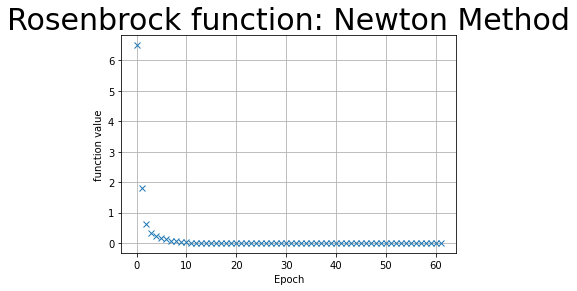

Optimal values are [1. 1.]
Absolute error in x is  1.1102230246251565e-16
Absolute error in y is 1.1102230246251565e-16


In [6]:
x=[0,0]
learning_rate=0.5
n_epochs=500
x_opt=opt.Newton(x,n_epochs,learning_rate)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

### ADAM Optimization

solution diverging at epoch no:  440
Optimal value of the function found =  0.000672037418392199


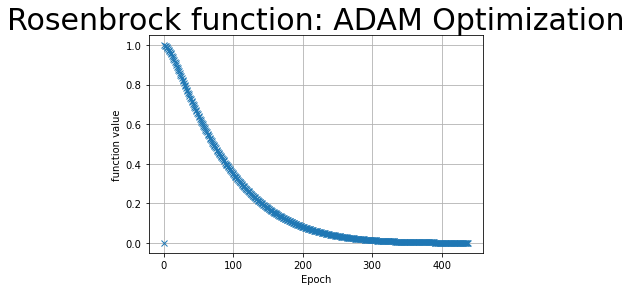

Optimal values are  [0.97456645 0.95028149]
Absolute error in x is  0.025433545148722758
Absolute error in y is 0.049718506038112786


In [7]:
# x=[0,0]
learning_rate=0.002
n_epochs=500
x_opt=opt.adam(x,n_epochs,alpha = 0.005, eps = 1.0e-12, beta_1=0.90, beta_2=0.999)
print('Optimal values are ', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

### Very fast simulated annealing

Starting Solution:  [1.72555115] [0.95034773]
[411.4719077]
Intial function value =  [411.4719077]
Final Solution:1.2405128581353397,1.539035915678236
Minimum Error = 0.05784911680889242
*****I am DONE ******


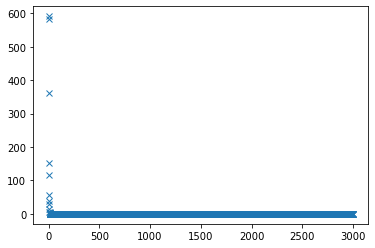

In [8]:
m_min = np.array([0.0, 0.0])
m_max = np.array([2.0, 2.0])
d0=0.0
m_final,ee,all_points=opt.vfsa('func2',d0,m_min,m_max,500.0,3000,5)
print('Final Solution:'+str(m_final[0])+','+str(m_final[1]))
#print('Error Value:'+str(func_ss(m_final[0],m_final[1])))
print('Minimum Error =', np.min(ee))
print('*****I am DONE ******')
plt.plot(ee,'x')

# Now we will use optimization routines from scipy

In [9]:
# Now using the CG method, using the first derivative and a few options:
x0=[0,0]
res=minimize(rosen,x0,method='CG',jac=rosen_der,  options={
    'disp': True})
print(res.x)
print(res.values())
print(res.items())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 42
         Gradient evaluations: 42
[0.99999205 0.99998409]
dict_values([6.317906212824002e-11, array([-6.80688612e-06, -4.54187405e-06]), 42, 42, 0, True, 'Optimization terminated successfully.', array([0.99999205, 0.99998409]), 18])
dict_items([('fun', 6.317906212824002e-11), ('jac', array([-6.80688612e-06, -4.54187405e-06])), ('nfev', 42), ('njev', 42), ('status', 0), ('success', True), ('message', 'Optimization terminated successfully.'), ('x', array([0.99999205, 0.99998409])), ('nit', 18)])


### BFGS

Look back at the code for Newton's method and observe that the update to the solution vector $x_{k+1}$ is

$\mathbf{x_{k+1}} = \mathbf{x_k} - (\nabla\nabla f(\mathbf{x}))^{-1}\nabla f(\mathbf{x})$

where $\nabla f$ is the gradient of $f$ and $\nabla\nabla f$ is the Hessian of $f$

$\nabla\nabla f(\mathbf{x}) = 
\begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1x_2} & ... & \frac{\partial^2 f}{\partial x_1x_n}\\
\frac{\partial^2 f}{\partial x_2x_1} & \frac{\partial^2 f}{\partial x_2^2} & ... & \frac{\partial^2 f}{\partial x_2x_n}\\
\vdots & \vdots & \ddots & \vdots\\
\frac{\partial^2 f}{\partial x_nx_1} & \frac{\partial^2 f}{\partial x_nx_2} & ... & \frac{\partial^2 f}{\partial x_n^2}\\
\end{bmatrix}$

Inverting the Hessian is an extremely demanding computation for a large $x$ requiring $\mathcal O(n^3)$ floating point operations. BFGS avoids computing the inverse Hessian matrix with some numerical tricks. Since this is not a course on Numerical Analysis, we won't go into the details. But, you should know that this family of optimization methods that approximate the Hessian are called Quasi-Newton methods.

In [10]:
# Now using the BFGS algorithm, using the first derivative and a few options:
res = minimize(rosen, x0, method='BFGS', jac=rosen_der, options={
    'disp': True})
print(res.x)
print(res.message)
print(res.values())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
[0.99999913 0.99999825]
Optimization terminated successfully.
dict_values([7.717288356613562e-13, array([ 3.92841201e-06, -2.83120873e-06]), array([[0.49480256, 0.98953879],
       [0.98953879, 1.98387918]]), 24, 24, 0, True, 'Optimization terminated successfully.', array([0.99999913, 0.99999825]), 19])


In [11]:
# Newton-Conjugate Gradient algorithm is a modified Newton’s method and uses a conjugate gradient algorithm to (approximately) invert the local Hessian [NW]. 
res = minimize(rosen, x0, method='Newton-CG',
               jac=rosen_der, hess=rosen_hess,
               options={'xtol': 1e-8, 'disp': True})
print(res.x)
print(res.values())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 55
         Gradient evaluations: 55
         Hessian evaluations: 35
[1. 1.]
dict_values([3.2093766919136996e-18, array([ 5.94461863e-07, -2.98427461e-07]), 55, 55, 35, 0, True, 'Optimization terminated successfully.', array([1., 1.]), 35])


# Homework Assignment


1) What is a hyperparameter and what are the hyperparameters of the ADAM optimizer?


2) What values of $x,y$ minimize the Rosenbrock function according to the different optimizers? What value of the Rosenbrock function is acheived? Compute the aboslute error ${|x_{true}-x_{computed}|}$ for each method (for both $x$ and $y$) and see if different choices of hyperparameters effect this error. Note that the true global minimum is $0$ at $x=y=1$. Write a function to compute the absolute error since you will be doing this several times.  

3) Compare the convergence rate of the different optimizers. 

4) Consider the following optimization problem:

$\min \ (x^2+y^2)$

By computing the eigenvalues and checking the symmetry of the Hessian matrix, confirm that the Hessian is positive definite at the stationary point x = 0, y = 0 and that (0,0) is a local minimum. Show your work in a markdown cell.

5) A line search is a method for determining an optimal step length (learning rate) for gradient descent methods that is non-constant. After computing the gradient, a second step is taken to minimize the function along a line in the direction of the gradient. In this second step, the problem becomes:

$\min_\alpha f(\mathbf{x}_k-\alpha \mathbf{p}_{k})$ 

where $\mathbf{p} = \nabla f$ and $k$ indicates the $k^\textrm{th}$ iteration of gradient descent.

Improve the gradient descent algorithm by including a [line search](https://en.wikipedia.org/wiki/Line_search) using    [the golden section search](https://en.wikipedia.org/wiki/Golden-section_search) method to determine the optimal learning rate $\alpha$ at each iteration. The golden section search code is provided below. You will need to provide bounds for the learning rate. Start with a lower bound $a=10^{-5}$ and experiment with both lower bounds $a$ and upper bounds $b$. Comment on the improvement or lack thereof relative to standard gradient descent.

### Answer 1:

Hyperparameters are the parameters that the practitioners need to specify  to control the training process. The values of hyperparameters are not derived by the data. The hyperparameters for ADAM optimization are:
1. $\alpha$ - Learning rate
2. $\beta_1$ - Exponential decay rate for the first moment estimates
3. $\beta_2$ - Exponential decay rate for the second-moment estimates
4. $\epsilon$ - Prevents division by error

Reference - https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/


### Answer 2:

### Gradient Descent

Optimal value of the function found =  3.132439308613923e-05


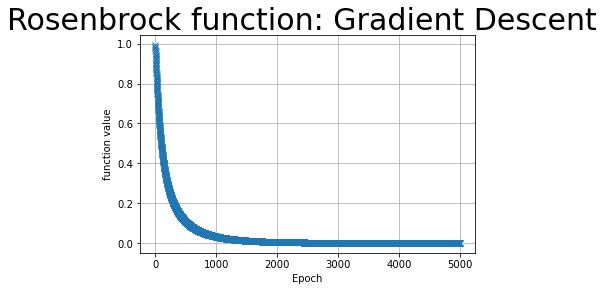

Optimal values are [0.99440769 0.98882419]
Absolute error in x is  0.005592314073232241
Absolute error in y is 0.011175807764687407


In [23]:
opt=Optimize()
x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=5000    # no of epochs
x_opt=opt.gd(x,nr,lr)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

1. On increasing number of epochs by keeping the learning rate to be equal to 0.002, the error decreases and the solution converges.
2. On increasing the learning rate more than 0.003, the solution starts to diverge. Number of epochs it takes for the solution to diverge also reduces as we increase the learning rate further.
3. On decreasing the learning rate, the convergence rate decreases.

### Newton's Method

Optimal value of the function found =  0.0


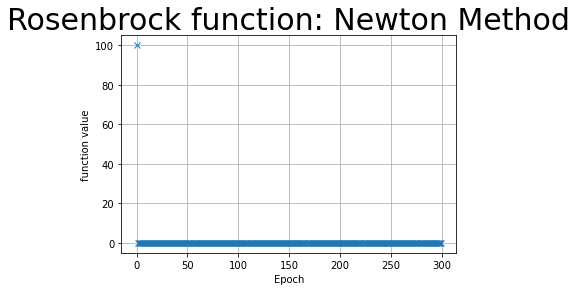

Optimal values are [1. 1.]
Absolute error in x is  0.0
Absolute error in y is 0.0


In [24]:
x=[0,0]
learning_rate=1
n_epochs=300
x_opt=opt.Newton(x,n_epochs,learning_rate)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

- On increasing the learning rate between 0.83 and 1.1, the solution does not diverge. It starts to diverge for learning rate greater than 1.1. 

### ADAM optimization

[x,y] = [0.98031894 0.96034676] and func_opt_value = 0.0004333762961982688

solution diverging at epoch no:  321
Optimal value of the function found =  1.4234755377474417e-05


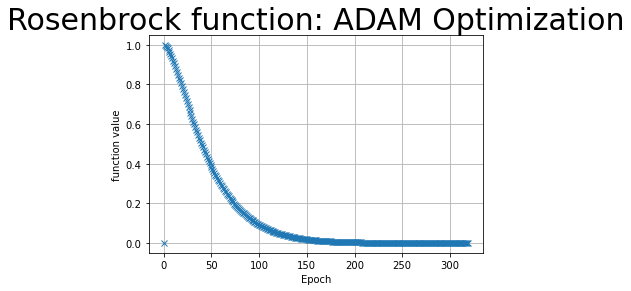

Optimal values are  [0.99657954 0.99333   ]
Absolute error in x is  0.0034204606411795124
Absolute error in y is 0.006669998479930439


In [116]:
 x=[0,0]
learning_rate=0.002
n_epochs=500
x_opt=opt.adam(x,n_epochs,alpha = 0.01, eps = 1.0e-11, beta_1=0.9, beta_2=0.99999)
print('Optimal values are ', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

1. Error increases on decreasing $\beta_1$ less than 0.9
2. Error increases on decreasing $\beta_2$ less than 0.99999

### Very fast simulated annealing

Starting Solution:  [1.66317819] [1.4889464]
[163.56769164]
Intial function value =  [163.56769164]
Final Solution:0.9452283770380119,0.8932745310464675
Minimum Error = 0.0030032486793495567
*****I am DONE ******
Absolute error in x is  0.05477162296198812
Absolute error in y is 0.10672546895353252


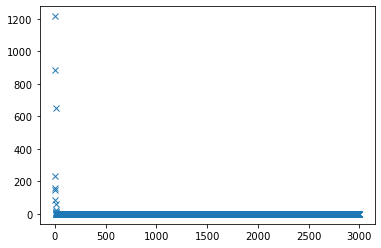

In [15]:
m_min = np.array([0.0, 0.0])
m_max = np.array([2.0, 2.0])
d0=0.0
t0 = 500
niter = 3000
nloop = 5
m_final,ee,all_points=opt.vfsa('func2',d0,m_min,m_max,t0,niter,nloop)
print('Final Solution:'+str(m_final[0])+','+str(m_final[1]))
#print('Error Value:'+str(func_ss(m_final[0],m_final[1])))
print('Minimum Error =', np.min(ee))
print('*****I am DONE ******')
plt.plot(ee,'x')
abs_e_x = opt.absolute_error(1,m_final[0])
abs_e_y = opt.absolute_error(1,m_final[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

### Answer 3

Convergence rate comparison

VFSA > Newton's Method > ADAM > Gradient Descent

### Answer 4

$f(x,y) = x^2 + y^2$

$\frac{\partial f}{\partial x} = 2x, \frac{\partial f}{\partial y} = 2y$

$\frac{\partial^2 f}{\partial x^2} = 2, \frac{\partial^2 f}{\partial y^2} = 2, \frac{\partial^2 f}{\partial x \partial y} = 0$

Therefore, Hessian Matrix is 

$H_f$ = [2,0;0,2]

The eigenvalues (the diagonal entries since the matrix is diagonal) are $\lambda_1, \lambda_2 = 2 > 0$ and the matrix $H_f$ is symmetric, therefore the Hessian Matrix is positive definite at $(x,y)$ = $(0,0)$

Local minimum is attained at $\frac{\partial f}{\partial x} = 0, \frac{\partial f}{\partial y} = 0$ since the Hessian matrix is positive definite. Therefore, $(x,y)$ at local minimum are $(0,0)$

### Answer 5

The functions are added in the class Optimize() above

### Case 1: a = 1e-5, b = 1e-3
Line search limits the performance of the gradient descent method for the above value of a and b

Optimal value of the function found =  0.24301226422750835


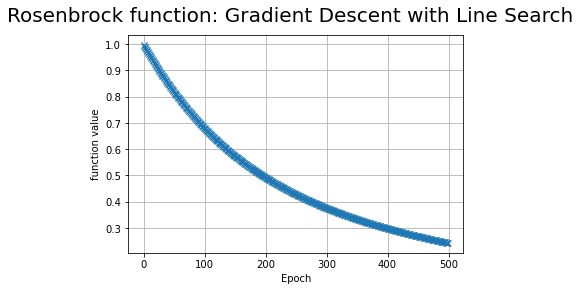

Optimal values are [0.50765549 0.25524601]
Absolute error in x is  0.49234451037581206
Absolute error in y is 0.7447539948784975
Optimal value of the function found =  0.10647176035928493


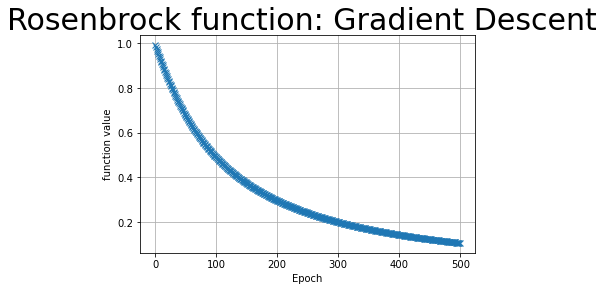

Optimal values are [0.67407395 0.45281374]
Absolute error in x is  0.32592604998803154
Absolute error in y is 0.5471862647753145


In [16]:
x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd_line_search(x,nr,lr,1e-5,1e-3)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd(x,nr,lr)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

### Case 2: a = 1e-5, b = 1e-2
Line search improves the performance of the gradient descent method for the above value of a and b

Optimal value of the function found =  0.015239676764075408


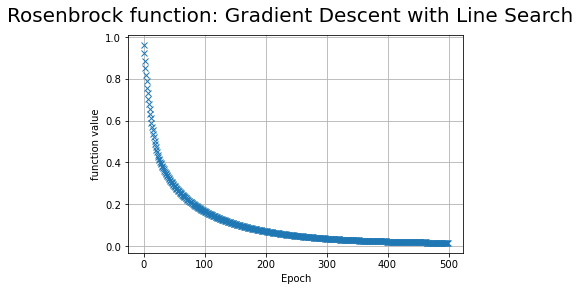

Optimal values are [0.87655134 0.76837472]
Absolute error in x is  0.1234486587363458
Absolute error in y is 0.23162527764068275
Optimal value of the function found =  0.10647176035928493


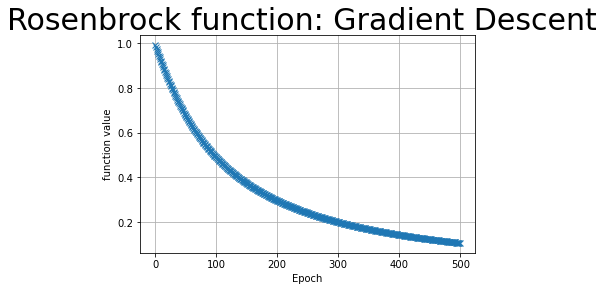

Optimal values are [0.67407395 0.45281374]
Absolute error in x is  0.32592604998803154
Absolute error in y is 0.5471862647753145


In [17]:
x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd_line_search(x,nr,lr,1e-5,1e-2)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd(x,nr,lr)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

### Case 3: a = 1e-5, b = 1e-1

Line search improves the performance of the gradient descent method for the above value of a and b


Optimal value of the function found =  0.02655546419842923


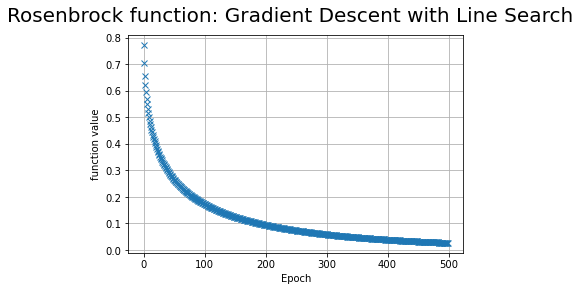

Optimal values are [0.83704153 0.70064162]
Absolute error in x is  0.1629584709061641
Absolute error in y is 0.2993583828427824
Optimal value of the function found =  0.10647176035928493


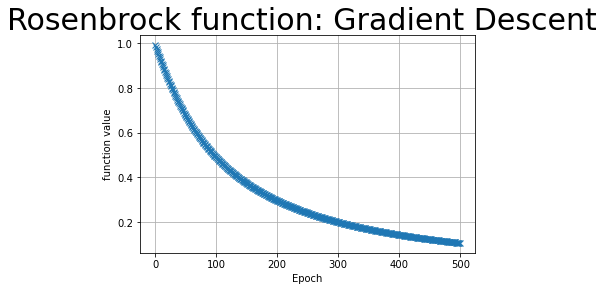

Optimal values are [0.67407395 0.45281374]
Absolute error in x is  0.32592604998803154
Absolute error in y is 0.5471862647753145


In [18]:
x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd_line_search(x,nr,lr,1e-5,1e-1)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd(x,nr,lr)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

### Case 4: a = 1e-4, b = 1e-1

Line search improves the performance of the gradient descent method for the above value of a and b


Optimal value of the function found =  0.02687734241550486


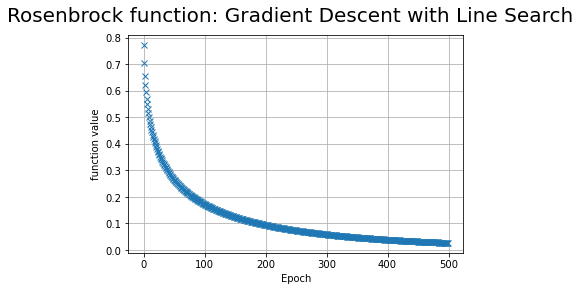

Optimal values are [0.83605689 0.69899304]
Absolute error in x is  0.1639431061337454
Absolute error in y is 0.30100695521388154
Optimal value of the function found =  0.10647176035928493


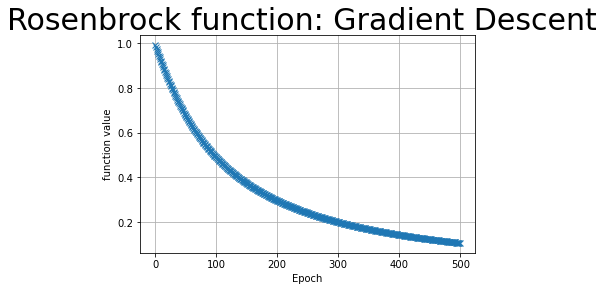

Optimal values are [0.67407395 0.45281374]
Absolute error in x is  0.32592604998803154
Absolute error in y is 0.5471862647753145


In [19]:
x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd_line_search(x,nr,lr,1e-4,1e-1)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd(x,nr,lr)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

### Case 5, a = 1e-4, b = 1e-2

Line search improves the performance of the gradient descent method for the above value of a and b

Optimal value of the function found =  0.01452242682342145


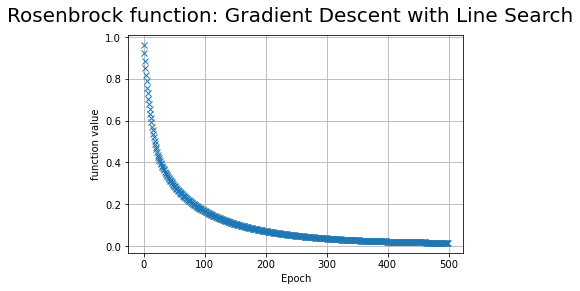

Optimal values are [0.87949145 0.77353937]
Absolute error in x is  0.12050854821187007
Absolute error in y is 0.22646063490823098
Optimal value of the function found =  0.10647176035928493


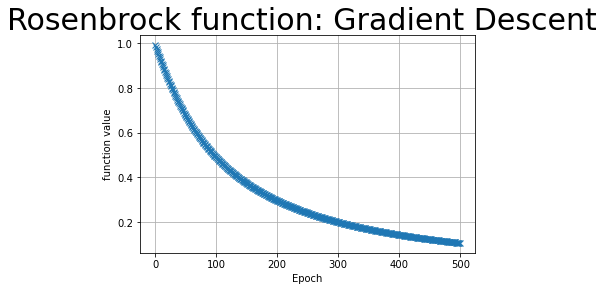

Optimal values are [0.67407395 0.45281374]
Absolute error in x is  0.32592604998803154
Absolute error in y is 0.5471862647753145


In [20]:
x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd_line_search(x,nr,lr,1e-4,1e-2)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd(x,nr,lr)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

### Case 6, a = 1e-4, b = 1e-3

Line search limits the performance of the gradient descent method for the above value of a and b

Optimal value of the function found =  0.24292478914203647


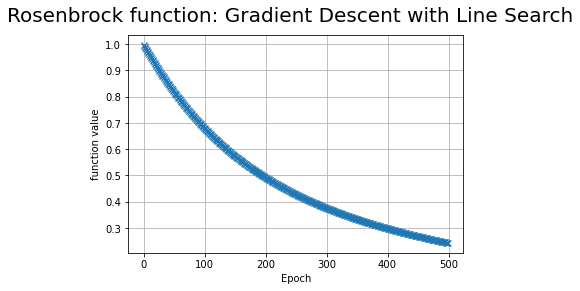

Optimal values are [0.50774411 0.25533644]
Absolute error in x is  0.49225589381817103
Absolute error in y is 0.7446635614752699
Optimal value of the function found =  0.10647176035928493


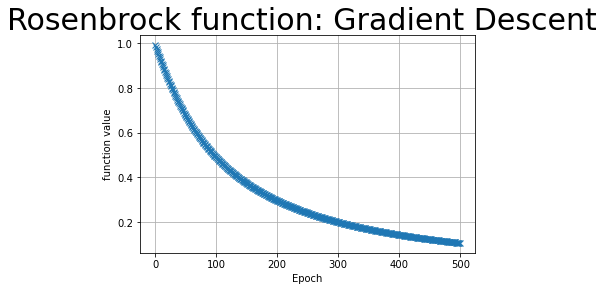

Optimal values are [0.67407395 0.45281374]
Absolute error in x is  0.32592604998803154
Absolute error in y is 0.5471862647753145


In [21]:
x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd_line_search(x,nr,lr,1e-4,1e-3)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)

x=[0.0,0.0]  # starting solution
lr=0.002   # learning rate
nr=500    # no of epochs
x_opt=opt.gd(x,nr,lr)
print('Optimal values are', x_opt)
abs_e_x = opt.absolute_error(1,x_opt[0])
abs_e_y = opt.absolute_error(1,x_opt[1])
print('Absolute error in x is ',abs_e_x)
print('Absolute error in y is',abs_e_y)